In [1]:
import pandas
import feather
import datetime
import numpy
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from davitpy.models import *
from davitpy import utils
from aacgmv2 import convert_mlt
%matplotlib inline

In [2]:
sizeAsyCutoff = 50.

In [3]:
# We need to combine the potential model with
# the SAPS location model to limit the data
# to locations where we see SAPS
def saps_pred_func(x, y, dstInp):
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.93, 2.67e-3, 2.21, 3e-3, 3.86, 6.03e-2, -0.51, 5.57e-2, 0.985, 0.93e-3, 0.633 )
    a_sx = 3.11
    b_sx = 0.00371
    a_sy = 1.72
    b_sy = 0.000819
    a_xo = 4.59
    b_xo = 0.0633
    a_yo = -1.19
    b_yo = 0.0321
    a_o = 0.893
    b_o = -0.00147
    theta = 0.692
    # parameters from fitting
#     (a_sx, b_sx, a_sy, b_sy, a_xo, b_xo, a_yo, b_yo, a_o, b_o, theta) = \
#         ( 2.58, -0.007, 1.03, -0.023, 3.99,  \
#            0.041, -1.63, 0.02, 1.11, 0.006, 0.68 )
    sigma_x = a_sx + b_sx * dstInp
    sigma_y = a_sy + b_sy * dstInp
    xo = a_xo + b_xo * dstInp
    yo = a_yo + b_yo * dstInp
    amplitude = a_o + b_o * dstInp    
    
    a = (numpy.cos(theta)**2)/(2*sigma_x**2) + (numpy.sin(theta)**2)/(2*sigma_y**2)
    b = -(numpy.sin(2*theta))/(4*sigma_x**2) + (numpy.sin(2*theta))/(4*sigma_y**2)
    c = (numpy.sin(theta)**2)/(2*sigma_x**2) + (numpy.cos(theta)**2)/(2*sigma_y**2)
    outProb = amplitude*numpy.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return outProb

### build test dst indices and plot them
sapsPredDF = pandas.DataFrame(columns=["normMLT", "normLAT", "probSAPS", "MLT", "Lat", "dst_index"])
latArr = []
mltArr = []
normLatArr = []
normMltArr = []
probSapsArr = []
dstArr = []
dstIndSel = [ -120., -100., -75., -50, -25., -5. ,0. ]
for z in dstIndSel:
    for x in range( -7, 8 ):
        for y in range( -12, 10 ):        
            normLatArr.append( x )
            normMltArr.append( y )
            dstArr.append( z )
            if y > 0:
                mltArr.append( y )
            else:
                mltArr.append( y + 24 )
            latArr.append( x + 57. )
            probSapsArr.append( saps_pred_func(x,y,z) )
        
sapsPredDF["MLT"] = mltArr
sapsPredDF["Lat"] = latArr
sapsPredDF["normMLT"] = normMltArr
sapsPredDF["normLAT"] = normLatArr
sapsPredDF["probSAPS"] = probSapsArr
sapsPredDF["dst_index"] = dstArr
# Limit SAPS location to where prob > 0.2
sapsPredDF = sapsPredDF[ sapsPredDF["probSAPS"] >= 0.05\
                       ].reset_index(drop=True)
sapsPredDF.head()

,normMLT,normLAT,probSAPS,MLT,Lat,dst_index
0,-6,-7,0.089514,18,50.0,-120.0
1,-5,-7,0.162988,19,50.0,-120.0
2,-4,-7,0.223678,20,50.0,-120.0
3,-3,-7,0.231361,21,50.0,-120.0
4,-2,-7,0.180367,22,50.0,-120.0


In [4]:
potDF = feather.read_dataframe('../data/potDF.feather')
potDF.head()

,AsyH,MLAT,normMLT,potential,normLAT,potMagn,mlt
0,45.0,56.5,-7.0,-2.21,-2.0,2.21,17.0
1,45.0,57.0,-7.0,-3.82,-1.5,3.82,17.0
2,45.0,57.5,-7.0,-5.75,-1.0,5.75,17.0
3,45.0,58.5,-7.0,-7.77,0.0,7.77,17.0
4,45.0,59.0,-7.0,-10.10,0.5,10.10,17.0


In [5]:
# Get number of values for different Asy Inds
# discard those values which have low counts
sizeAsyDF = potDF.groupby("AsyH").size().reset_index()
sizeAsyDF.columns = [ "AsyH", "asyCnt" ]
sizeAsyDF = sizeAsyDF[ sizeAsyDF["asyCnt"] >= sizeAsyCutoff]
potDF = pandas.merge(potDF, sizeAsyDF,\
                     on = "AsyH", how="inner"\
                    ).reset_index(drop=True)
# Get peak potentials
peakPotDF = potDF[[ "AsyH", "potMagn" ]].groupby( "AsyH" ).max().reset_index()
peakPotDF.columns = [ "AsyH", "peakPotMagn" ]

In [27]:
# We'll model peak potential as a log function of AsyH index.
def peak_pot_fit_func( (asy), a_asy, b_asy):
    peakPotVal = a_asy + b_asy*numpy.log(asy)    
    return peakPotVal

poptPeakPot, pcovPeakPot = curve_fit(peak_pot_fit_func,\
                               (peakPotDF['AsyH'].T),\
                               peakPotDF['peakPotMagn'], p0=(1, 0.1))

print "Vpeak = ", str( round(poptPeakPot[0],2) ), "+", str( round(poptPeakPot[1],2) ), "x log(AsyH-index)"

# get pred peak potentials
peakPotDF["predPeakPot"] = [ peak_pot_fit_func(x, *poptPeakPot) for x in peakPotDF["AsyH"] ]

Vpeak =  -6.47 + 9.48 x log(AsyH-index)


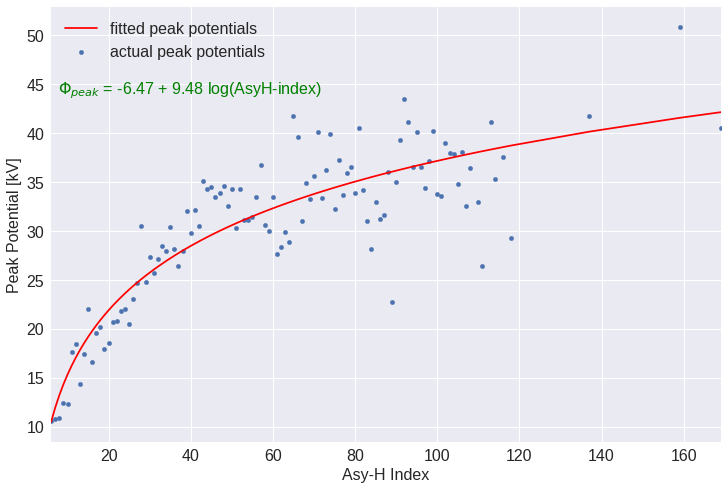

In [31]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)


peakPotDF.plot( x="AsyH", y="peakPotMagn", kind="scatter", ax=ax, label="actual peak potentials" )
peakPotDF.plot( x="AsyH", y="predPeakPot", c="r", ax=ax, label="fitted peak potentials" )

printText = "$\Phi_{peak}$ = " +\
            str( round(poptPeakPot[0],2) ) +\
            " + " + str( round(poptPeakPot[1],2) ) +\
            " log(AsyH-index)"

ax.text(0.01, 0.8,  printText,
            transform=ax.transAxes,
            color='green', fontsize=16)

ax.set_xlabel("Asy-H Index", fontsize=16)
ax.set_ylabel("Peak Potential [kV]", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

f.savefig( "../figs/potMagFit.pdf" )